In [28]:
import sys

import networkx as nx
import igraph as ig
from networkx.generators.community import LFR_benchmark_graph

import numpy as np
import time

import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 15

#sys.path.append("/home/oriol/Documents/Trento/JacobianGeometry/Code/Dynamics_v2/")
#sys.path.append("/Users/giacomobarzon/Desktop/jacobian_geometry/Code_8thJune/Dynamics_v2/")
sys.path.append("/home/barzon/Network_geometry/Code_8thJune/Dynamics_v2/")

import CommonFunctions as cf
import plotter

import importlib
importlib.reload(cf)

from matplotlib.colors import LogNorm
lw = 2.5

In [2]:
def remove_digits(string):
    '''
    Remove digits from string
    '''
    return ''.join([i for i in string if not i.isdigit()])

def clean_func_name(string):
    '''
    Clean name of functional networks
    '''
    return string.split('_')[2]

v_remove_digits = np.vectorize(remove_digits)
v_clean_func_name = np.vectorize(clean_func_name)

In [3]:
def eucl_distance_3d(v1, v2):
    '''
    Euclidean distance btw two vectors
    '''
    return np.sqrt( np.sum( (v1-v2)**2 ) )

def find_nearest_single(vect, dataset):
    '''
    Find nearest value in dataset
    '''
    tt = 0
    d_tmp = np.inf
    
    for index, val in enumerate(dataset):
        if eucl_distance_3d(vect, val)<d_tmp:
            d_tmp = eucl_distance_3d(vect, val)
            tt = index
            
    return tt

def find_nearest(dataset1, dataset2):
    '''
    Find nearest value between all elements of two datasets
    '''
    nearest = np.zeros(len(dataset1))
    
    for index, val in enumerate(dataset1):
        nearest[index] = find_nearest_single(val, dataset2)
        
    return nearest.astype(int)

def get_reordered_matrix(mat, order):
    '''
    Get reordered matrix
    '''
    mat_reorder = np.zeros(mat.shape)

    for index, val in enumerate(mat_reorder[order]):
        mat_reorder[index] = mat[order][index][order]
        
    return mat_reorder

def ras_to_mni(vec):
    '''
    From RAS to MNI coordinates
    '''
    t_mat = np.array([[1.0022, 0.0071, -0.0177, 0.0528],
                 [-0.0146, 0.9990, 0.0027, -1.5519],
                 [0.0129, 0.0094, 1.0027, -1.2012]])
    
    vec = np.append(vec, 1.)
        
    return t_mat.dot(vec)

In [4]:
# Load connectivity data
#data_path = '/Users/giacomobarzon/Desktop/jacobian_geometry/data/'
data_path = '/home/barzon/Network_geometry/data/'

connectome = np.loadtxt(data_path+'group_mean_connectivity_matrix_file.txt')
names = np.genfromtxt(data_path+'group_mean_region_names_full_file.txt',dtype='str')
short = np.genfromtxt(data_path+'group_mean_region_names_abbrev_file.txt',dtype='str')
coords = np.loadtxt(data_path+'group_mean_region_xyz_centers_file.txt')

short = v_remove_digits(short) # remove digits from names

# Load functional atlas
# https://github.com/ThomasYeoLab/CBIG/blob/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_900Parcels_7Networks_order_FSLMNI152_1mm.Centroid_RAS.csv
funct_atlas = np.genfromtxt(data_path+'Schaefer2018_900Parcels_7Networks_order_FSLMNI152_1mm_Centroid_RAS.csv',dtype='str',delimiter=',')
names_func = funct_atlas[1:,1]
coords_func = funct_atlas[1:,2:].astype(float)

names_func = v_clean_func_name(names_func)

rsn = np.unique(names_func)

# Transform RAS to MNI
# * maybe not needed...
coords_func = np.array([ras_to_mni(vec) for vec in coords_func])

In [5]:
# Find RSN to which each structural node belongs to
index_nearest = find_nearest(coords, coords_func)
func_net = names_func[index_nearest]

# Get the reorder for structural nodes
reorder = []

for name in rsn:
    tmp = np.where(func_net == name)[0]
    reorder.append(tmp)
    
reorder = np.concatenate(reorder)

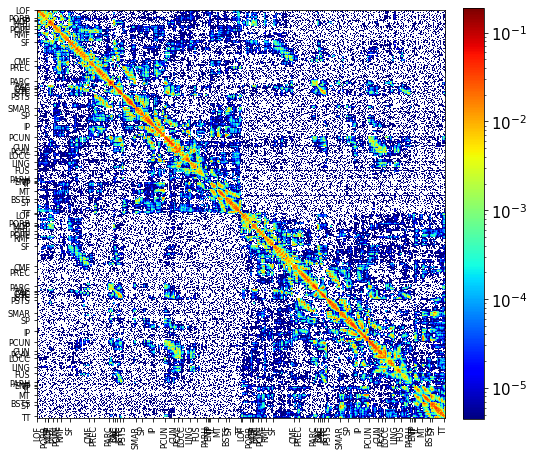

In [6]:
plt.figure(figsize=(8,8))

## Names to print
label_to_print = np.where(short[1:]!=short[:-1])[0] + 1
label_to_print = np.insert(label_to_print, 0, 0)

im = plt.imshow(connectome, cmap='jet', norm=LogNorm())
plt.colorbar(im,fraction=0.046, pad=0.04)

plt.yticks(ticks=label_to_print, labels=short[label_to_print], fontsize=8)
plt.xticks(ticks=label_to_print, labels=short[label_to_print], rotation=90, fontsize=8)

plt.show()

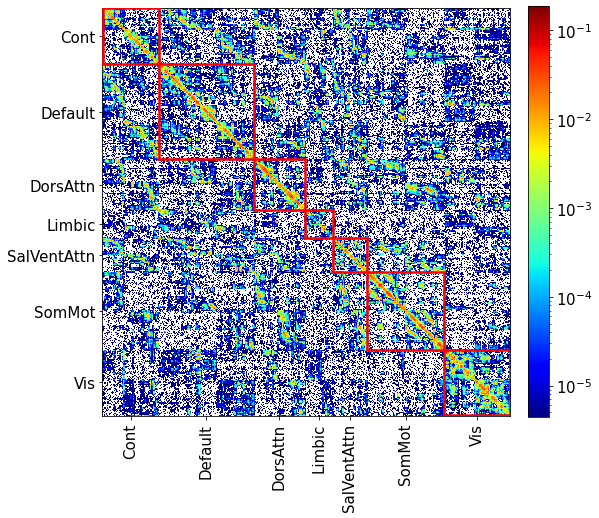

In [35]:
plt.figure(figsize=(8,8))


## Names to print
label_to_print = np.where(short[1:]!=short[:-1])[0] + 1
label_to_print = np.insert(label_to_print, 0, 0)

im = plt.imshow(get_reordered_matrix(connectome, reorder), cmap='jet', norm=LogNorm())
plt.colorbar(im,fraction=0.046, pad=0.04)

net_border = np.where(func_net[reorder][1:] != func_net[reorder][:-1])[0]
net_border = np.append(net_border, len(func_net)-1)

prev = 0
for val in net_border:
    plt.axhline(val, xmin=prev/len(func_net), xmax=val/len(func_net), c='red', lw=lw, zorder=10)
    plt.axvline(val, ymin=1-prev/len(func_net), ymax=1-val/len(func_net), c='red', lw=lw, zorder=10)
    
    plt.axhline(prev, xmin=prev/len(func_net), xmax=val/len(func_net), c='red', lw=lw, zorder=10)
    plt.axvline(prev, ymin=1-prev/len(func_net), ymax=1-val/len(func_net), c='red', lw=lw, zorder=10)
    
    #plt.axhline(val, c='red')
    #plt.axvline(val, c='red')
    prev = val

net_border = np.append(0, net_border)

plt.yticks(ticks=(net_border[1:]+net_border[:-1])/2, labels=rsn)
plt.xticks(ticks=(net_border[1:]+net_border[:-1])/2, labels=rsn, rotation=90)

plt.show()

In [30]:
def Simu(dynamics, G, infoG):
    """
    Inputs: dynamics (any from  dynamics_list = ['Mutualistic', 'Biochemical', 'Population', 'Regulatory',
                                                 'Epidemics','Synchronization', 'Neuronal', 'NoisyVM'])
            Network topology G
            infoG (list): Info about the network. infoG[0] = network_type; infoG[i>0] = parameters
    """
    print('-------- GRAPH DISTANCES --------')
    start_time = time.time()
    
    num_nodes = len(G)
    num_time_points = 200 # small to decrease computational load
    times = np.linspace(0, 400, num = num_time_points) #time to find the steady state    
    #str_tp = "np.logspace(-2, 2., num = num_time_points)" 
    times_perturbation = np.linspace(0, 1000, num = 1001)#times at which we look how the perturbation evolves

    if dynamics in ['Mutualistic', 'Population', 'Regulatory','Synchronization', 'Neuronal']:
        perturbation_strength = 0.5
    elif dynamics in ['Biochemical', 'Epidemics', 'NoisyVM']:
        perturbation_strength = 0.05
    else:
        print('Dynamics not valid. Manual Exiting')
        exit()
    
    #if nx.is_connected(G) == 0:
    #    raise ValueError('The network should be in a single component. Exit!')
    
    ### JACOBIAN
    print('[*] JACOBIAN DISTANCE')
    #Integration to get the steady state
    '''
    initial_state = np.random.random(len(G.nodes()))   

    print('Integration up to steady state...')
    SteadyState_ref = cf.Numerical_Integration(G, dynamics, initial_state, times = times, fixed_node = 1e+6, show = 1)
    SteadyState_ref = SteadyState_ref[-1]

    # analytical expression of Jacobian
    print('Evaluating jacobian distance...')
    d_jac = cf.Jacobian(G, dynamics, SteadyState_ref, times_perturbation, return_snapshot=True)
    '''
    ### DIFFUSION
    print('[*] DIFFUSION DISTANCE')
    print('Evaluating diffusion distance...')
    d_diff = cf.Laplacian(G, times_perturbation, norm=True, return_snapshot=True)
    
    return d_diff

In [ ]:
res_human = Simu('Synchronization', connectome, [])

-------- GRAPH DISTANCES --------
[*] JACOBIAN DISTANCE
[*] DIFFUSION DISTANCE
Evaluating diffusion distance...
largest eig: 1.7057041486834965
eigs sum: 998.0


  0%|          | 0/1001 [00:00<?, ?it/s]

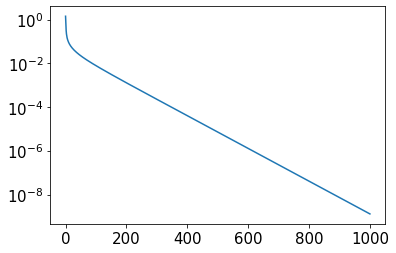

In [32]:
plt.plot(res_human[0])

plt.yscale('log')
plt.show()

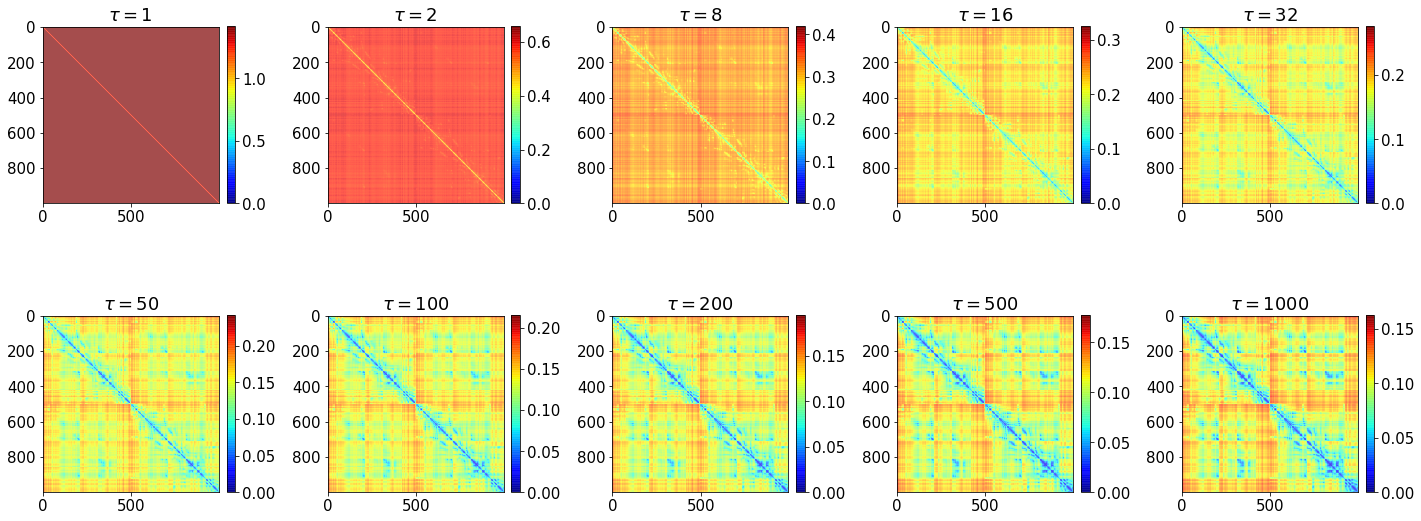

In [37]:
t_print = [1, 2, 8, 16, 32, 50, 100, 200, 500, 1000]

plt.figure(figsize=(20,30))

for i, t in enumerate(t_print):
    plt.subplot(2,len(t_print)//2,i+1)
    
    im = plt.imshow(res_human[1][i], cmap='jet', alpha=0.7)
    plt.title(r'$\tau = $'+str(t))
    
    plt.colorbar(im, fraction=0.046, pad=0.04)

plt.subplots_adjust(wspace=0, hspace=-1.1)
plt.tight_layout()
plt.show()

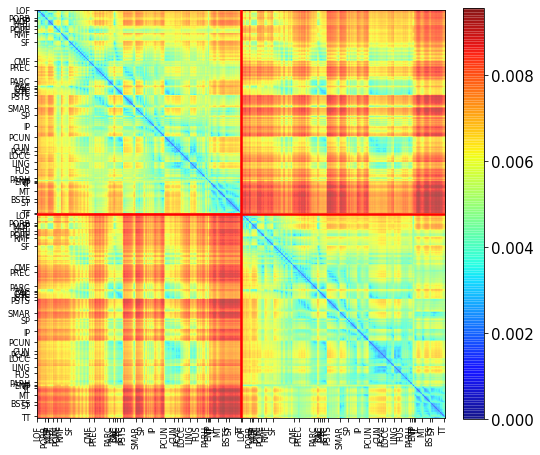

In [38]:
plt.figure(figsize=(8,8))

lw = 2.5

im = plt.imshow(np.mean(res_human[1],axis=0), cmap='jet', alpha=0.7)
plt.colorbar(im,fraction=0.046, pad=0.04)

plt.yticks(ticks=label_to_print, labels=short[label_to_print], fontsize=8)
plt.xticks(ticks=label_to_print, labels=short[label_to_print], rotation=90, fontsize=8)

plt.axhline(len(connectome)/2, c='red', lw=lw, zorder=10)
plt.axvline(len(connectome)/2, c='red', lw=lw, zorder=10)

plt.show()

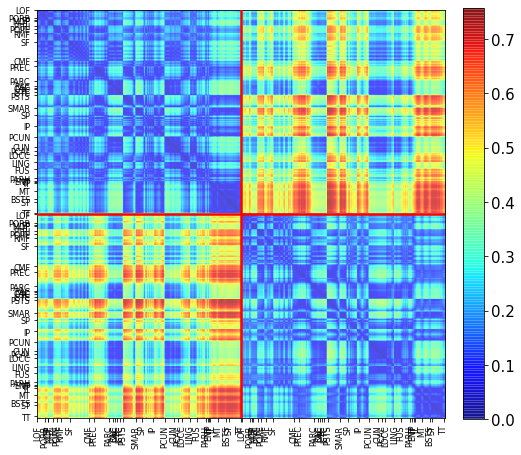

In [20]:
plt.figure(figsize=(8,8))

lw = 2.5

im = plt.imshow(plotter.get_average_norm(res_human[1]), cmap='jet', alpha=0.7)
plt.colorbar(im,fraction=0.046, pad=0.04)

plt.yticks(ticks=label_to_print, labels=short[label_to_print], fontsize=8)
plt.xticks(ticks=label_to_print, labels=short[label_to_print], rotation=90, fontsize=8)

plt.axhline(len(connectome)/2, c='red', lw=lw, zorder=10)
plt.axvline(len(connectome)/2, c='red', lw=lw, zorder=10)

plt.show()

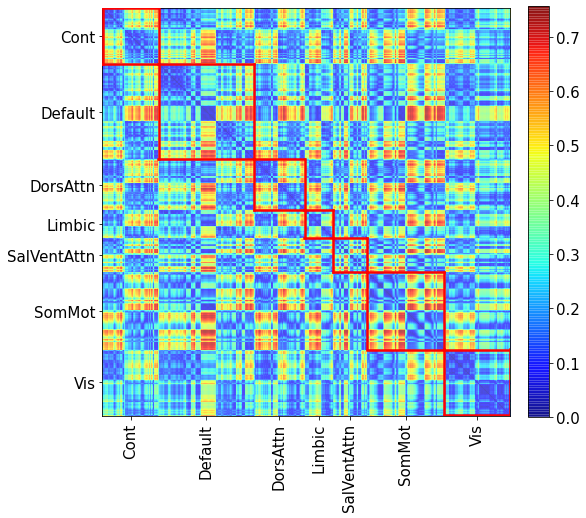

In [22]:
plt.figure(figsize=(8,8))

average_dist_mat = plotter.get_average_norm(res_human[1])
im = plt.imshow(get_reordered_matrix(average_dist_mat, reorder), cmap='jet', alpha=0.7)
plt.colorbar(im,fraction=0.046, pad=0.04)

net_border = np.where(func_net[reorder][1:] != func_net[reorder][:-1])[0]
net_border = np.append(net_border, len(func_net)-1)

prev = 0
for val in net_border:
    plt.axhline(val, xmin=prev/len(func_net), xmax=val/len(func_net), c='red', lw=lw, zorder=10)
    plt.axvline(val, ymin=1-prev/len(func_net), ymax=1-val/len(func_net), c='red', lw=lw, zorder=10)
    
    plt.axhline(prev, xmin=prev/len(func_net), xmax=val/len(func_net), c='red', lw=lw, zorder=10)
    plt.axvline(prev, ymin=1-prev/len(func_net), ymax=1-val/len(func_net), c='red', lw=lw, zorder=10)
    
    #plt.axhline(val, c='red')
    #plt.axvline(val, c='red')
    prev = val

net_border = np.append(0, net_border)

plt.yticks(ticks=(net_border[1:]+net_border[:-1])/2, labels=rsn)
plt.xticks(ticks=(net_border[1:]+net_border[:-1])/2, labels=rsn, rotation=90)
    
plt.show()